# Trajectory Evaluation Tutorial

**Learning Objectives:**
- Understand 6 trajectory evaluation metrics (exact match, in-order, any-order, precision, recall, single-tool use)
- Apply metrics to real agent execution traces
- Interpret metric scores and identify failure patterns
- Generate radar charts for visual comparison
- Export evaluation results for dashboard integration

**Prerequisites:**
- Read `trajectory_evaluation_techniques.md` (20-25 min)
- Familiarity with agent trajectories and tool calling

**Execution Time:**
- DEMO mode: ~3 minutes (20 trajectories)
- FULL mode: ~8 minutes (100 trajectories)

**Cost:**
- $0.00 (all metrics are rule-based, no LLM API calls)

## 1. Setup & Configuration

In [ ]:
"""Setup cell: Import dependencies and configure execution mode."""
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Add backend to path
sys.path.insert(0, str(Path.cwd().parent / "backend"))

from trajectory_evaluation import TrajectoryEvaluator, TrajectoryVisualizer

# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("✅ Setup complete!")
print("Imported: TrajectoryEvaluator, TrajectoryVisualizer")

ModuleNotFoundError: No module named 'trajectory_evaluation'

In [2]:
"""Configuration: Set execution mode (DEMO or FULL)."""

# ========== CONFIGURATION ==========
EXECUTION_MODE = "DEMO"  # Change to "FULL" for complete evaluation
# ==================================

if EXECUTION_MODE == "DEMO":
    NUM_TRAJECTORIES = 20
    ESTIMATED_TIME = "3 minutes"
    ESTIMATED_COST = "$0.00"
elif EXECUTION_MODE == "FULL":
    NUM_TRAJECTORIES = 100
    ESTIMATED_TIME = "8 minutes"
    ESTIMATED_COST = "$0.00"
else:
    raise ValueError("EXECUTION_MODE must be 'DEMO' or 'FULL'")

print(f"🎯 Mode: {EXECUTION_MODE}")
print(f"📊 Evaluating {NUM_TRAJECTORIES} trajectories")
print(f"⏱️  Estimated time: {ESTIMATED_TIME}")
print(f"💰 Estimated cost: {ESTIMATED_COST} (all metrics are rule-based)")
print("\n✅ Ready to begin!")

🎯 Mode: DEMO
📊 Evaluating 20 trajectories
⏱️  Estimated time: 3 minutes
💰 Estimated cost: $0.00 (all metrics are rule-based)

✅ Ready to begin!


## 2. Load Datasets

In [4]:
"""Load reference trajectories and test set."""

# Load reference trajectories (ground truth)
references_path = Path("data/trajectory_references.json")
if not references_path.exists():
    raise FileNotFoundError(f"Missing file: {references_path}")

with open(references_path, encoding="utf-8") as f:
    references_data = json.load(f)

# Create reference lookup
references = {
    ref["trajectory_id"]: ref["reference_actions"]
    for ref in references_data["references"]
}

# Load test set (agent execution traces)
test_set_path = Path("data/trajectory_test_set.json")
if not test_set_path.exists():
    raise FileNotFoundError(f"Missing file: {test_set_path}")

with open(test_set_path, encoding="utf-8") as f:
    test_data = json.load(f)

test_cases = test_data["test_cases"][:NUM_TRAJECTORIES]

print(f"✅ Loaded {len(references)} reference trajectories")
print(f"✅ Loaded {len(test_cases)} test cases")
print("\nTest set statistics:")
print(json.dumps(test_data["statistics"], indent=2))

✅ Loaded 50 reference trajectories
✅ Loaded 20 test cases

Test set statistics:
{
  "total_tests": 100,
  "exact_matches": 30,
  "in_order_partial": 25,
  "any_order_matches": 20,
  "precision_recall_cases": 15,
  "failure_cases": 10
}


## 3. Trajectory Format Overview

Understanding the data structure for trajectory evaluation.

In [5]:
"""Display sample reference trajectory."""

# Get first reference trajectory
sample_ref_id = "ref_001"
sample_ref_full = [
    ref for ref in references_data["references"] if ref["trajectory_id"] == sample_ref_id
][0]

print("📋 Sample Reference Trajectory (Ground Truth)")
print("=" * 60)
print(f"ID: {sample_ref_full['trajectory_id']}")
print(f"Task: {sample_ref_full['task_description']}")
print(f"Type: {sample_ref_full['task_type']}")
print(f"Complexity: {sample_ref_full['complexity']}")
print("\nReference Actions:")
for i, action in enumerate(sample_ref_full["reference_actions"], 1):
    print(f"  {i}. {action}")
print(f"\nMetadata: {json.dumps(sample_ref_full['metadata'], indent=2)}")

📋 Sample Reference Trajectory (Ground Truth)
ID: ref_001
Task: Find vegetarian pasta recipes
Type: recipe_search
Complexity: simple

Reference Actions:
  1. classify_query
  2. search_recipes
  3. format_response

Metadata: {
  "num_tools": 1,
  "num_steps": 3,
  "expected_duration_seconds": 2.5
}


In [6]:
"""Display sample test trajectory."""

sample_test = test_cases[0]

print("\n🤖 Sample Test Trajectory (Agent Execution)")
print("=" * 60)
print(f"Test ID: {sample_test['test_id']}")
print(f"Reference ID: {sample_test['reference_id']}")
print(f"Task: {sample_test['task_description']}")
print("\nActual Actions (Predicted):")
for i, action in enumerate(sample_test["actual_actions"], 1):
    print(f"  {i}. {action}")
print(f"\nExecution Metadata: {json.dumps(sample_test['execution_metadata'], indent=2)}")
print(f"\nExpected Metrics: {json.dumps(sample_test['expected_metrics'], indent=2)}")


🤖 Sample Test Trajectory (Agent Execution)
Test ID: test_001
Reference ID: ref_001
Task: Find vegetarian pasta recipes

Actual Actions (Predicted):
  1. classify_query
  2. search_recipes
  3. format_response

Execution Metadata: {
  "duration_seconds": 2.3,
  "num_llm_calls": 2,
  "success": true
}

Expected Metrics: {
  "exact_match": 1.0,
  "in_order_match": 1.0,
  "any_order_match": 1.0,
  "precision": 1.0,
  "recall": 1.0,
  "single_tool_use": true
}


## 4. Metric 1: Exact Match

**Definition:** Strictest metric. Returns 1.0 only if predicted trajectory exactly matches reference (same actions, same order).

**Use Case:** Testing deterministic agents where sequence must be precise.

**Formula:** `1.0 if reference == predicted else 0.0`

In [7]:
"""Demonstrate exact match metric."""

evaluator = TrajectoryEvaluator()

# Example 1: Perfect match
ref1 = ["classify_query", "search_recipes", "format_response"]
pred1 = ["classify_query", "search_recipes", "format_response"]
score1 = evaluator.exact_match(ref1, pred1)

print("Example 1: Perfect Match")
print(f"Reference:  {ref1}")
print(f"Predicted:  {pred1}")
print(f"Exact Match: {score1:.2f} ✅\n")

# Example 2: Wrong order
ref2 = ["classify_query", "search_recipes", "format_response"]
pred2 = ["search_recipes", "classify_query", "format_response"]
score2 = evaluator.exact_match(ref2, pred2)

print("Example 2: Wrong Order")
print(f"Reference:  {ref2}")
print(f"Predicted:  {pred2}")
print(f"Exact Match: {score2:.2f} ❌")
print("Reason: Order matters for exact match\n")

# Example 3: Extra actions
ref3 = ["classify_query", "search_recipes", "format_response"]
pred3 = ["classify_query", "search_recipes", "validate_results", "format_response"]
score3 = evaluator.exact_match(ref3, pred3)

print("Example 3: Extra Actions")
print(f"Reference:  {ref3}")
print(f"Predicted:  {pred3}")
print(f"Exact Match: {score3:.2f} ❌")
print("Reason: Extra actions fail exact match (use in_order_match instead)")

Example 1: Perfect Match
Reference:  ['classify_query', 'search_recipes', 'format_response']
Predicted:  ['classify_query', 'search_recipes', 'format_response']
Exact Match: 1.00 ✅

Example 2: Wrong Order
Reference:  ['classify_query', 'search_recipes', 'format_response']
Predicted:  ['search_recipes', 'classify_query', 'format_response']
Exact Match: 0.00 ❌
Reason: Order matters for exact match

Example 3: Extra Actions
Reference:  ['classify_query', 'search_recipes', 'format_response']
Predicted:  ['classify_query', 'search_recipes', 'validate_results', 'format_response']
Exact Match: 0.00 ❌
Reason: Extra actions fail exact match (use in_order_match instead)


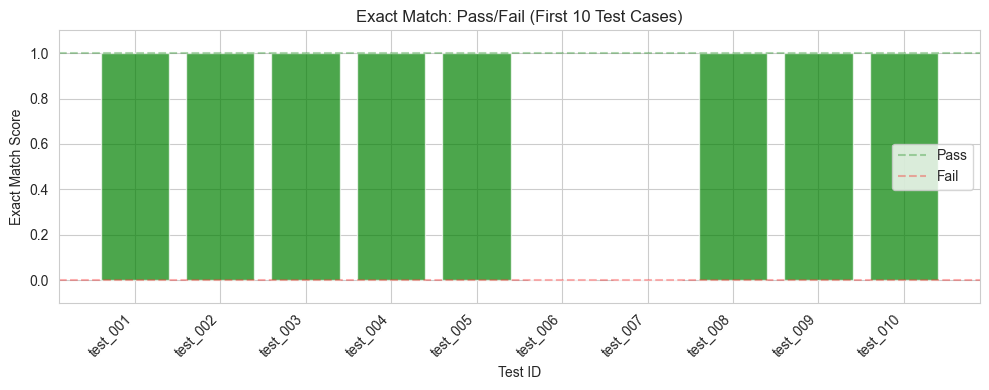


✅ Exact Match Pass Rate: 80.0%


In [8]:
"""Visualize exact match pass/fail on sample test cases."""

# Evaluate first 10 test cases
exact_match_results = []
for test in test_cases[:10]:
    ref = references[test["reference_id"]]
    pred = test["actual_actions"]
    score = evaluator.exact_match(ref, pred)
    exact_match_results.append({"test_id": test["test_id"], "score": score})

# Create visualization
df = pd.DataFrame(exact_match_results)
colors = ["green" if s == 1.0 else "red" for s in df["score"]]

plt.figure(figsize=(10, 4))
plt.bar(df["test_id"], df["score"], color=colors, alpha=0.7)
plt.axhline(y=1.0, color="green", linestyle="--", alpha=0.3, label="Pass")
plt.axhline(y=0.0, color="red", linestyle="--", alpha=0.3, label="Fail")
plt.xlabel("Test ID")
plt.ylabel("Exact Match Score")
plt.title("Exact Match: Pass/Fail (First 10 Test Cases)")
plt.xticks(rotation=45, ha="right")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.tight_layout()
plt.show()

pass_rate = (df["score"] == 1.0).sum() / len(df) * 100
print(f"\n✅ Exact Match Pass Rate: {pass_rate:.1f}%")

**Exercise:** Why did test_001 pass but test_006 fail? Examine their trajectories.

**Hint:** Look at the `actual_actions` and compare to `reference_actions` for both tests.

## 5. Metric 2: In-Order Match

**Definition:** Checks if all reference actions appear in predicted trajectory in the same order, but allows extra actions between them.

**Use Case:** Evaluating agents that may add validation or logging steps.

**Formula:** `1.0 if reference is subsequence of predicted else 0.0`

In [9]:
"""Demonstrate in-order match metric."""

# Example 1: Extra actions (in order)
ref1 = ["classify_query", "search_recipes", "format_response"]
pred1 = ["classify_query", "search_recipes", "validate_results", "format_response"]
exact_score = evaluator.exact_match(ref1, pred1)
in_order_score = evaluator.in_order_match(ref1, pred1)

print("Example 1: Extra Actions (in order)")
print(f"Reference:  {ref1}")
print(f"Predicted:  {pred1}")
print(f"Exact Match:    {exact_score:.2f} ❌")
print(f"In-Order Match: {in_order_score:.2f} ✅")
print("Insight: Extra 'validate_results' allowed in in-order match\n")

# Example 2: Out of order
ref2 = ["classify_query", "search_recipes", "format_response"]
pred2 = ["search_recipes", "classify_query", "format_response"]
in_order_score2 = evaluator.in_order_match(ref2, pred2)

print("Example 2: Out of Order")
print(f"Reference:  {ref2}")
print(f"Predicted:  {pred2}")
print(f"In-Order Match: {in_order_score2:.2f} ❌")
print("Reason: 'classify_query' comes AFTER 'search_recipes' (wrong order)\n")

# Example 3: Missing action
ref3 = ["classify_query", "search_recipes", "format_response"]
pred3 = ["classify_query", "format_response"]
in_order_score3 = evaluator.in_order_match(ref3, pred3)

print("Example 3: Missing Action")
print(f"Reference:  {ref3}")
print(f"Predicted:  {pred3}")
print(f"In-Order Match: {in_order_score3:.2f} ❌")
print("Reason: Missing 'search_recipes' action")

Example 1: Extra Actions (in order)
Reference:  ['classify_query', 'search_recipes', 'format_response']
Predicted:  ['classify_query', 'search_recipes', 'validate_results', 'format_response']
Exact Match:    0.00 ❌
In-Order Match: 1.00 ✅
Insight: Extra 'validate_results' allowed in in-order match

Example 2: Out of Order
Reference:  ['classify_query', 'search_recipes', 'format_response']
Predicted:  ['search_recipes', 'classify_query', 'format_response']
In-Order Match: 0.00 ❌
Reason: 'classify_query' comes AFTER 'search_recipes' (wrong order)

Example 3: Missing Action
Reference:  ['classify_query', 'search_recipes', 'format_response']
Predicted:  ['classify_query', 'format_response']
In-Order Match: 0.00 ❌
Reason: Missing 'search_recipes' action


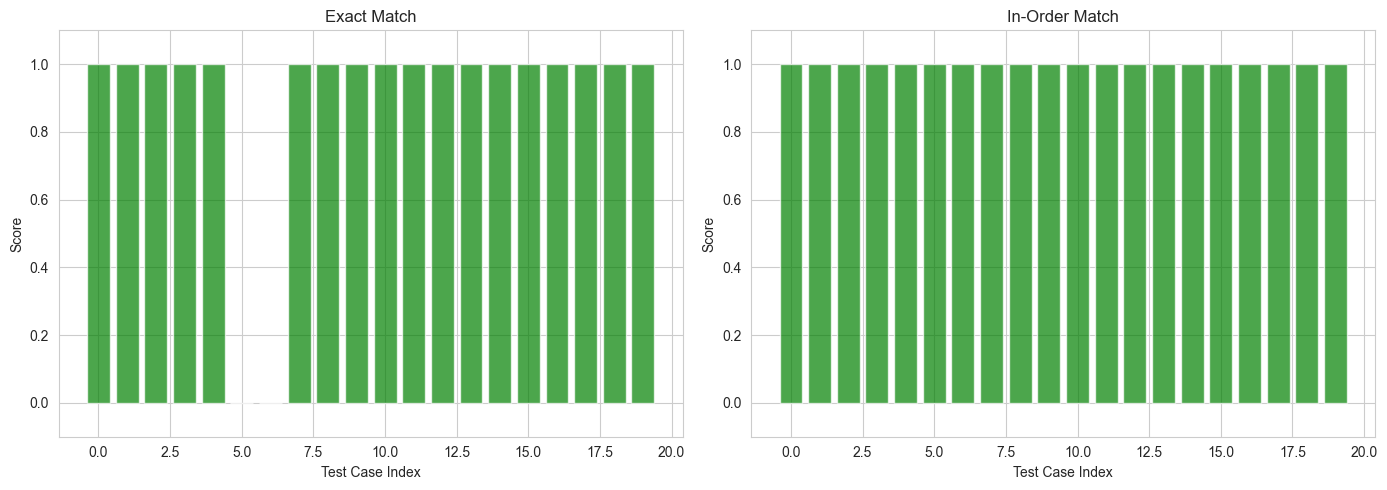


📊 Comparison (First 20 Test Cases):
Exact Match Pass: 18/20 (90.0%)
In-Order Match Pass: 20/20 (100.0%)
Improvement: +2 cases pass with in-order match


In [10]:
"""Compare exact match vs in-order match."""

comparison_results = []
for test in test_cases[:20]:
    ref = references[test["reference_id"]]
    pred = test["actual_actions"]
    exact = evaluator.exact_match(ref, pred)
    in_order = evaluator.in_order_match(ref, pred)
    comparison_results.append(
        {"test_id": test["test_id"], "exact_match": exact, "in_order_match": in_order}
    )

df = pd.DataFrame(comparison_results)

# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Exact Match
colors_exact = ["green" if s == 1.0 else "red" for s in df["exact_match"]]
axes[0].bar(range(len(df)), df["exact_match"], color=colors_exact, alpha=0.7)
axes[0].set_title("Exact Match")
axes[0].set_xlabel("Test Case Index")
axes[0].set_ylabel("Score")
axes[0].set_ylim(-0.1, 1.1)

# In-Order Match
colors_in_order = ["green" if s == 1.0 else "red" for s in df["in_order_match"]]
axes[1].bar(range(len(df)), df["in_order_match"], color=colors_in_order, alpha=0.7)
axes[1].set_title("In-Order Match")
axes[1].set_xlabel("Test Case Index")
axes[1].set_ylabel("Score")
axes[1].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

exact_pass = (df["exact_match"] == 1.0).sum()
in_order_pass = (df["in_order_match"] == 1.0).sum()
print("\n📊 Comparison (First 20 Test Cases):")
print(f"Exact Match Pass: {exact_pass}/20 ({exact_pass/20*100:.1f}%)")
print(f"In-Order Match Pass: {in_order_pass}/20 ({in_order_pass/20*100:.1f}%)")
print(f"Improvement: +{in_order_pass - exact_pass} cases pass with in-order match")

**Key Insight:** In-order match is more lenient than exact match, useful for agents that add extra steps (logging, validation) without changing core workflow.

## 6. Metric 3: Any-Order Match

**Definition:** Checks if all reference actions are present in predicted trajectory, ignoring order. Handles duplicates correctly.

**Use Case:** Evaluating parallel agents or workflows where order doesn't matter.

**Formula:** `1.0 if all reference actions present (with correct counts) else 0.0`

In [11]:
"""Demonstrate any-order match metric."""

# Example 1: Out of order (but all present)
ref1 = ["classify_query", "retrieve_thematic_verses", "synthesize_response", "format_response"]
pred1 = ["classify_query", "synthesize_response", "retrieve_thematic_verses", "format_response"]
exact_score = evaluator.exact_match(ref1, pred1)
in_order_score = evaluator.in_order_match(ref1, pred1)
any_order_score = evaluator.any_order_match(ref1, pred1)

print("Example 1: Out of Order (but all present)")
print(f"Reference:  {ref1}")
print(f"Predicted:  {pred1}")
print(f"Exact Match:     {exact_score:.2f} ❌")
print(f"In-Order Match:  {in_order_score:.2f} ❌")
print(f"Any-Order Match: {any_order_score:.2f} ✅")
print("Use Case: Parallel execution where order doesn't matter\n")

# Example 2: Handles duplicates correctly
ref2 = ["retrieve_verse", "retrieve_verse", "compare_verses"]
pred2 = ["retrieve_verse", "retrieve_verse", "compare_verses"]
pred2_wrong = ["retrieve_verse", "compare_verses"]  # Missing one retrieve_verse

any_order_correct = evaluator.any_order_match(ref2, pred2)
any_order_wrong = evaluator.any_order_match(ref2, pred2_wrong)

print("Example 2: Duplicate Handling")
print(f"Reference:  {ref2}")
print(f"Predicted (correct):  {pred2}")
print(f"Any-Order Match: {any_order_correct:.2f} ✅\n")

print(f"Predicted (wrong):  {pred2_wrong}")
print(f"Any-Order Match: {any_order_wrong:.2f} ❌")
print("Reason: Must have 2x 'retrieve_verse', not just 1")

Example 1: Out of Order (but all present)
Reference:  ['classify_query', 'retrieve_thematic_verses', 'synthesize_response', 'format_response']
Predicted:  ['classify_query', 'synthesize_response', 'retrieve_thematic_verses', 'format_response']
Exact Match:     0.00 ❌
In-Order Match:  0.00 ❌
Any-Order Match: 1.00 ✅
Use Case: Parallel execution where order doesn't matter

Example 2: Duplicate Handling
Reference:  ['retrieve_verse', 'retrieve_verse', 'compare_verses']
Predicted (correct):  ['retrieve_verse', 'retrieve_verse', 'compare_verses']
Any-Order Match: 1.00 ✅

Predicted (wrong):  ['retrieve_verse', 'compare_verses']
Any-Order Match: 0.00 ❌
Reason: Must have 2x 'retrieve_verse', not just 1


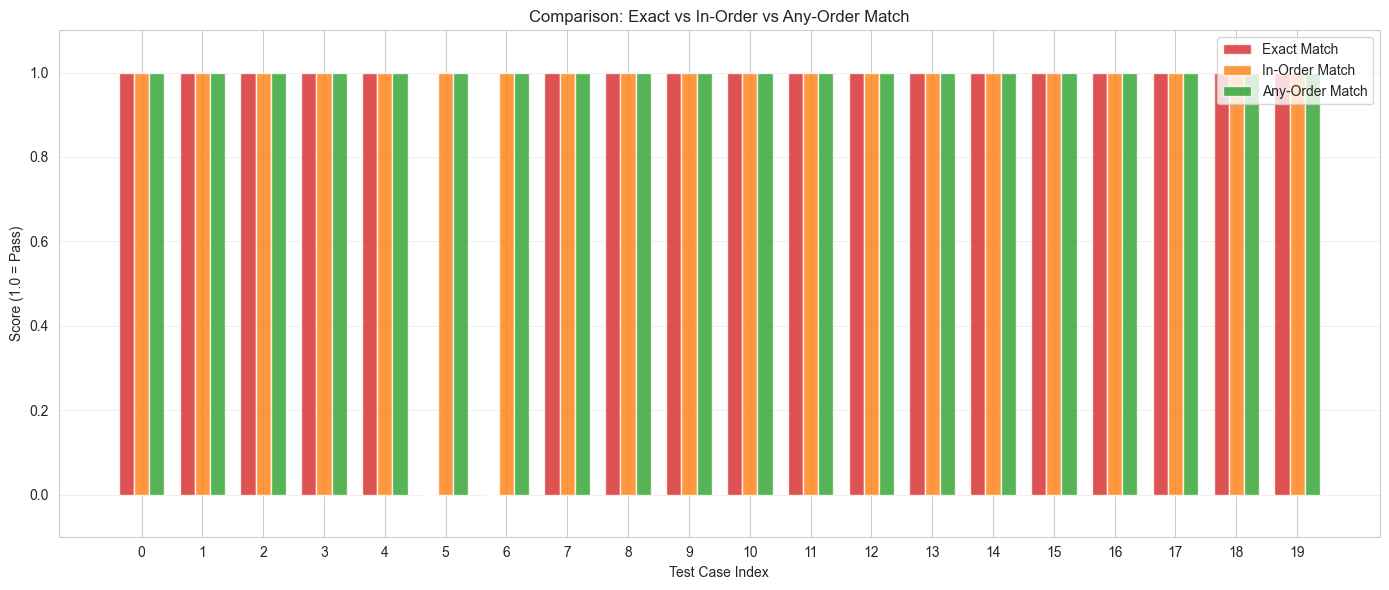


📊 Pass Rates (First 20 Test Cases):
Exact Match:     18/20 (90.0%)
In-Order Match:  20/20 (100.0%)
Any-Order Match: 20/20 (100.0%)


In [11]:
"""Compare all three binary metrics."""

comparison_results = []
for test in test_cases[:20]:
    ref = references[test["reference_id"]]
    pred = test["actual_actions"]
    exact = evaluator.exact_match(ref, pred)
    in_order = evaluator.in_order_match(ref, pred)
    any_order = evaluator.any_order_match(ref, pred)
    comparison_results.append(
        {
            "test_id": test["test_id"],
            "exact": exact,
            "in_order": in_order,
            "any_order": any_order,
        }
    )

df = pd.DataFrame(comparison_results)

# Create grouped bar chart
x = np.arange(len(df))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - width, df["exact"], width, label="Exact Match", alpha=0.8, color="#d62728")
ax.bar(x, df["in_order"], width, label="In-Order Match", alpha=0.8, color="#ff7f0e")
ax.bar(x + width, df["any_order"], width, label="Any-Order Match", alpha=0.8, color="#2ca02c")

ax.set_xlabel("Test Case Index")
ax.set_ylabel("Score (1.0 = Pass)")
ax.set_title("Comparison: Exact vs In-Order vs Any-Order Match")
ax.set_xticks(x)
ax.set_xticklabels(range(len(df)))
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Pass Rates (First 20 Test Cases):")
print(f"Exact Match:     {(df['exact'] == 1.0).sum()}/20 ({(df['exact'] == 1.0).sum()/20*100:.1f}%)")
print(f"In-Order Match:  {(df['in_order'] == 1.0).sum()}/20 ({(df['in_order'] == 1.0).sum()/20*100:.1f}%)")
print(
    f"Any-Order Match: {(df['any_order'] == 1.0).sum()}/20 ({(df['any_order'] == 1.0).sum()/20*100:.1f}%)"
)

**⚠️ Warning:** Any-order match may hide bugs where action sequence matters. Use only for truly parallel workflows.

## 7. Metric 4: Precision

**Definition:** Fraction of predicted actions that are correct (appear in reference).

**Use Case:** Detecting hallucinated or unnecessary tool calls.

**Formula:** `correct_predictions / total_predictions`

**Interpretation:**
- High precision (0.9+): Agent rarely hallucinates tools
- Low precision (0.5-): Agent calls many wrong/extra tools

In [12]:
"""Demonstrate precision metric."""

# Example 1: Perfect precision
ref1 = ["classify_query", "search_recipes", "format_response"]
pred1 = ["classify_query", "search_recipes"]  # Missing 1, but no extras
precision1 = evaluator.precision(ref1, pred1)
recall1 = evaluator.recall(ref1, pred1)

print("Example 1: Perfect Precision (but incomplete)")
print(f"Reference:  {ref1}")
print(f"Predicted:  {pred1}")
print(f"Precision: {precision1:.2f} ✅ (all predictions correct)")
print(f"Recall:    {recall1:.2f} ❌ (missing 'format_response')\n")

# Example 2: Low precision (hallucinated tools)
ref2 = ["classify_query", "search_recipes", "format_response"]
pred2 = ["classify_query", "retrieve_verse", "synthesize_response", "format_response"]
precision2 = evaluator.precision(ref2, pred2)
recall2 = evaluator.recall(ref2, pred2)

print("Example 2: Low Precision (hallucinated tools)")
print(f"Reference:  {ref2}")
print(f"Predicted:  {pred2}")
print(f"Precision: {precision2:.2f} ❌ (2/4 predictions wrong)")
print(f"Recall:    {recall2:.2f} ✅ (2/3 reference actions found)")
print("Insight: Agent called wrong tools (retrieve_verse, synthesize_response)\n")

# Example 3: Extra validation steps
ref3 = ["classify_query", "search_recipes", "format_response"]
pred3 = [
    "classify_query",
    "search_recipes",
    "validate_results",
    "rank_by_rating",
    "format_response",
]
precision3 = evaluator.precision(ref3, pred3)
recall3 = evaluator.recall(ref3, pred3)

print("Example 3: Extra Validation Steps")
print(f"Reference:  {ref3}")
print(f"Predicted:  {pred3}")
print(f"Precision: {precision3:.2f} (3/5 correct, 2 extras)")
print(f"Recall:    {recall3:.2f} ✅ (all reference actions found)")
print("Insight: Extra steps reduce precision but increase recall")

Example 1: Perfect Precision (but incomplete)
Reference:  ['classify_query', 'search_recipes', 'format_response']
Predicted:  ['classify_query', 'search_recipes']
Precision: 1.00 ✅ (all predictions correct)
Recall:    0.67 ❌ (missing 'format_response')

Example 2: Low Precision (hallucinated tools)
Reference:  ['classify_query', 'search_recipes', 'format_response']
Predicted:  ['classify_query', 'retrieve_verse', 'synthesize_response', 'format_response']
Precision: 0.50 ❌ (2/4 predictions wrong)
Recall:    0.67 ✅ (2/3 reference actions found)
Insight: Agent called wrong tools (retrieve_verse, synthesize_response)

Example 3: Extra Validation Steps
Reference:  ['classify_query', 'search_recipes', 'format_response']
Predicted:  ['classify_query', 'search_recipes', 'validate_results', 'rank_by_rating', 'format_response']
Precision: 0.60 (3/5 correct, 2 extras)
Recall:    1.00 ✅ (all reference actions found)
Insight: Extra steps reduce precision but increase recall


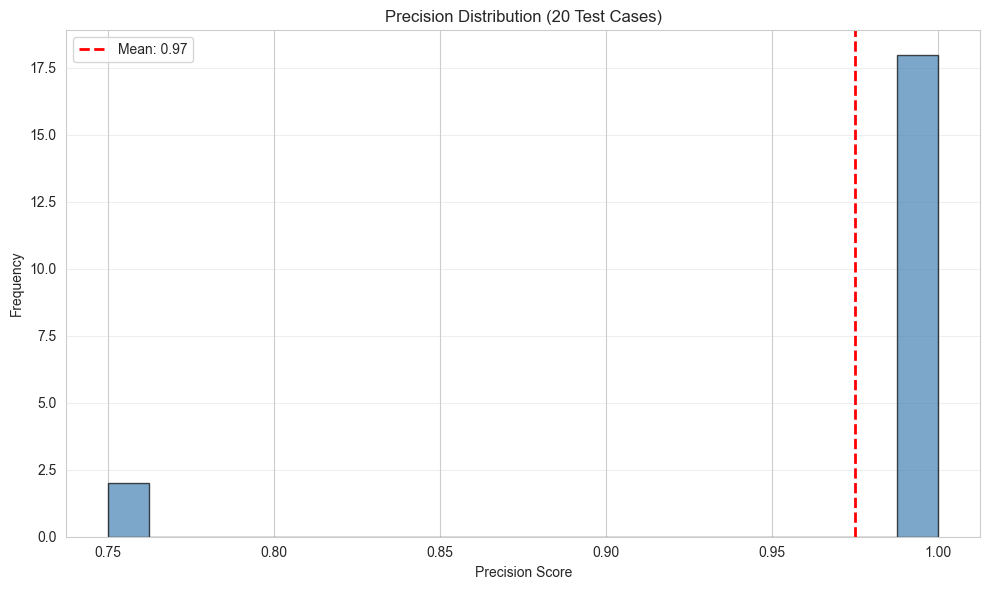


📊 Precision Statistics:
Mean:   0.97
Median: 1.00
Std:    0.07
Min:    0.75
Max:    1.00


In [14]:
"""Visualize precision distribution with Venn diagram concept."""

precision_scores = []
for test in test_cases[:NUM_TRAJECTORIES]:
    ref = references[test["reference_id"]]
    pred = test["actual_actions"]
    precision = evaluator.precision(ref, pred)
    precision_scores.append(precision)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(precision_scores, bins=20, color="steelblue", alpha=0.7, edgecolor="black")
plt.axvline(
    np.mean(precision_scores),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(precision_scores):.2f}",
)
plt.xlabel("Precision Score")
plt.ylabel("Frequency")
plt.title(f"Precision Distribution ({NUM_TRAJECTORIES} Test Cases)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Precision Statistics:")
print(f"Mean:   {np.mean(precision_scores):.2f}")
print(f"Median: {np.median(precision_scores):.2f}")
print(f"Std:    {np.std(precision_scores):.2f}")
print(f"Min:    {np.min(precision_scores):.2f}")
print(f"Max:    {np.max(precision_scores):.2f}")

**Interpretation Guide:**
- **Precision 1.0:** No hallucinated tools (all predictions correct)
- **Precision 0.8-0.9:** Few extra tools (acceptable for most use cases)
- **Precision 0.5-0.7:** Many extra tools (agent may be inefficient)
- **Precision <0.5:** Severe hallucination problem (debug agent logic)

## 8. Metric 5: Recall

**Definition:** Fraction of reference actions found in predicted trajectory.

**Use Case:** Detecting missing actions (incomplete execution).

**Formula:** `reference_actions_found / total_reference_actions`

**Interpretation:**
- High recall (0.9+): Agent completes workflow
- Low recall (0.5-): Agent skips critical steps

In [15]:
"""Demonstrate recall metric."""

# Example 1: Perfect recall (but extra actions)
ref1 = ["classify_query", "search_recipes", "format_response"]
pred1 = ["classify_query", "search_recipes", "validate_results", "format_response"]
precision1 = evaluator.precision(ref1, pred1)
recall1 = evaluator.recall(ref1, pred1)

print("Example 1: Perfect Recall (with extra actions)")
print(f"Reference:  {ref1}")
print(f"Predicted:  {pred1}")
print(f"Precision: {precision1:.2f} (3/4 correct, 1 extra)")
print(f"Recall:    {recall1:.2f} ✅ (all reference actions found)\n")

# Example 2: Low recall (missing actions)
ref2 = [
    "classify_query",
    "retrieve_thematic_verses",
    "synthesize_response",
    "format_response",
]
pred2 = ["classify_query", "format_response"]
precision2 = evaluator.precision(ref2, pred2)
recall2 = evaluator.recall(ref2, pred2)

print("Example 2: Low Recall (missing critical steps)")
print(f"Reference:  {ref2}")
print(f"Predicted:  {pred2}")
print(f"Precision: {precision2:.2f} ✅ (all predictions correct)")
print(f"Recall:    {recall2:.2f} ❌ (missing retrieve + synthesize)")
print("Issue: Agent skipped core logic steps\n")

# Example 3: Early termination
ref3 = [
    "classify_query",
    "retrieve_thematic_verses",
    "identify_context",
    "synthesize_practical_advice",
    "validate_attribution",
    "format_response",
]
pred3 = ["classify_query", "retrieve_thematic_verses", "identify_context"]
precision3 = evaluator.precision(ref3, pred3)
recall3 = evaluator.recall(ref3, pred3)

print("Example 3: Early Termination")
print(f"Reference:  {ref3}")
print(f"Predicted:  {pred3}")
print(f"Precision: {precision3:.2f} ✅ (all correct so far)")
print(f"Recall:    {recall3:.2f} ❌ (stopped at 50% completion)")
print("Issue: Agent terminated early (timeout? error?)")

Example 1: Perfect Recall (with extra actions)
Reference:  ['classify_query', 'search_recipes', 'format_response']
Predicted:  ['classify_query', 'search_recipes', 'validate_results', 'format_response']
Precision: 0.75 (3/4 correct, 1 extra)
Recall:    1.00 ✅ (all reference actions found)

Example 2: Low Recall (missing critical steps)
Reference:  ['classify_query', 'retrieve_thematic_verses', 'synthesize_response', 'format_response']
Predicted:  ['classify_query', 'format_response']
Precision: 1.00 ✅ (all predictions correct)
Recall:    0.50 ❌ (missing retrieve + synthesize)
Issue: Agent skipped core logic steps

Example 3: Early Termination
Reference:  ['classify_query', 'retrieve_thematic_verses', 'identify_context', 'synthesize_practical_advice', 'validate_attribution', 'format_response']
Predicted:  ['classify_query', 'retrieve_thematic_verses', 'identify_context']
Precision: 1.00 ✅ (all correct so far)
Recall:    0.50 ❌ (stopped at 50% completion)
Issue: Agent terminated early (t

/var/folders/4m/xzkr88kn5ms7g13s_qqfsx7m0000gn/T/ipykernel_5588/3631815785.py:37: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/4m/xzkr88kn5ms7g13s_qqfsx7m0000gn/T/ipykernel_5588/3631815785.py:37: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/4m/xzkr88kn5ms7g13s_qqfsx7m0000gn/T/ipykernel_5588/3631815785.py:37: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/4m/xzkr88kn5ms7g13s_qqfsx7m0000gn/T/ipykernel_5588/3631815785.py:37: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/rajnishkhatri/Documents/recipe-chatbot/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/rajnishkhatri/Documents/recipe-chatbot/.ve

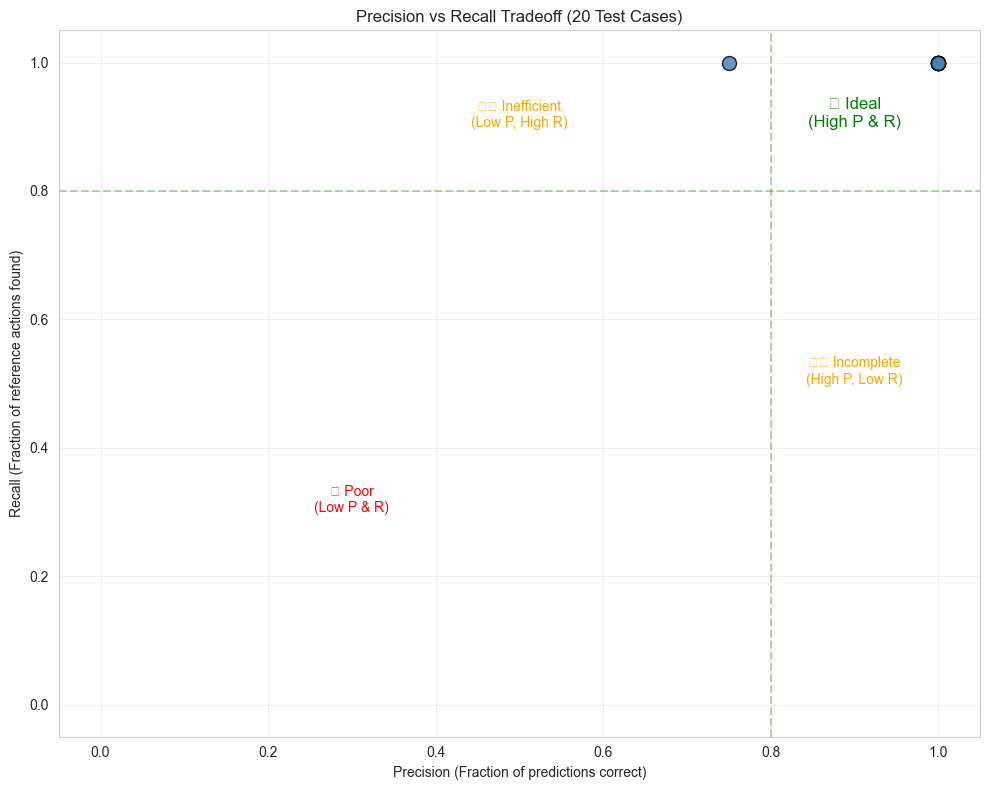


📊 Performance Clusters:
✅ Ideal (P≥0.8, R≥0.8):       18/20 (90.0%)
⚠️  Incomplete (P≥0.8, R<0.8):  0/20 (0.0%)
⚠️  Inefficient (P<0.8, R≥0.8): 2/20 (10.0%)
❌ Poor (P<0.8, R<0.8):        0/20 (0.0%)


In [15]:
"""Visualize precision vs recall tradeoff."""

precision_recall_data = []
for test in test_cases[:NUM_TRAJECTORIES]:
    ref = references[test["reference_id"]]
    pred = test["actual_actions"]
    precision = evaluator.precision(ref, pred)
    recall = evaluator.recall(ref, pred)
    precision_recall_data.append({"precision": precision, "recall": recall})

df = pd.DataFrame(precision_recall_data)

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(df["precision"], df["recall"], alpha=0.6, s=100, c="steelblue", edgecolors="black")

# Add quadrant lines
plt.axhline(y=0.8, color="green", linestyle="--", alpha=0.3)
plt.axvline(x=0.8, color="green", linestyle="--", alpha=0.3)

# Add quadrant labels
plt.text(0.9, 0.9, "✅ Ideal\n(High P & R)", fontsize=12, ha="center", color="green")
plt.text(
    0.9, 0.5, "⚠️ Incomplete\n(High P, Low R)", fontsize=10, ha="center", color="orange"
)
plt.text(
    0.5, 0.9, "⚠️ Inefficient\n(Low P, High R)", fontsize=10, ha="center", color="orange"
)
plt.text(0.3, 0.3, "❌ Poor\n(Low P & R)", fontsize=10, ha="center", color="red")

plt.xlabel("Precision (Fraction of predictions correct)")
plt.ylabel("Recall (Fraction of reference actions found)")
plt.title(f"Precision vs Recall Tradeoff ({NUM_TRAJECTORIES} Test Cases)")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Identify clusters
ideal = ((df["precision"] >= 0.8) & (df["recall"] >= 0.8)).sum()
incomplete = ((df["precision"] >= 0.8) & (df["recall"] < 0.8)).sum()
inefficient = ((df["precision"] < 0.8) & (df["recall"] >= 0.8)).sum()
poor = ((df["precision"] < 0.8) & (df["recall"] < 0.8)).sum()

print("\n📊 Performance Clusters:")
print(f"✅ Ideal (P≥0.8, R≥0.8):       {ideal}/{NUM_TRAJECTORIES} ({ideal/NUM_TRAJECTORIES*100:.1f}%)")
print(
    f"⚠️  Incomplete (P≥0.8, R<0.8):  {incomplete}/{NUM_TRAJECTORIES} ({incomplete/NUM_TRAJECTORIES*100:.1f}%)"
)
print(
    f"⚠️  Inefficient (P<0.8, R≥0.8): {inefficient}/{NUM_TRAJECTORIES} ({inefficient/NUM_TRAJECTORIES*100:.1f}%)"
)
print(f"❌ Poor (P<0.8, R<0.8):        {poor}/{NUM_TRAJECTORIES} ({poor/NUM_TRAJECTORIES*100:.1f}%)")

**Key Insight:** Precision and recall reveal different failure modes:
- **High Precision + Low Recall:** Agent is conservative (doesn't hallucinate) but incomplete
- **Low Precision + High Recall:** Agent is thorough but calls too many tools
- **Low Precision + Low Recall:** Critical bugs in agent logic

## 9. Metric 6: Single-Tool Use (Efficiency)

**Definition:** Efficiency penalty for excessive tool calls.

**Use Case:** Detecting retry loops, redundant calls, or inefficient workflows.

**Formula:** `min(1.0, reference_length / predicted_length)`

**Interpretation:**
- Score 1.0: Efficient (predicted ≤ reference length)
- Score 0.5: 2x more tool calls than needed
- Score 0.25: 4x more tool calls than needed

In [16]:
"""Demonstrate single-tool use (efficiency) metric."""

# Example 1: Efficient execution
ref1 = ["classify_query", "search_recipes", "format_response"]
pred1 = ["classify_query", "search_recipes", "format_response"]
efficiency1 = evaluator.single_tool_use(ref1, pred1)

print("Example 1: Efficient Execution")
print(f"Reference:  {ref1} (length: {len(ref1)})")
print(f"Predicted:  {pred1} (length: {len(pred1)})")
print(f"Efficiency: {efficiency1:.2f} ✅ (optimal)\n")

# Example 2: Retry loop (inefficient)
ref2 = ["classify_query", "search_recipes", "format_response"]
pred2 = [
    "classify_query",
    "search_recipes",
    "search_recipes",
    "search_recipes",
    "format_response",
]
efficiency2 = evaluator.single_tool_use(ref2, pred2)

print("Example 2: Retry Loop (Inefficient)")
print(f"Reference:  {ref2} (length: {len(ref2)})")
print(f"Predicted:  {pred2} (length: {len(pred2)})")
print(f"Efficiency: {efficiency2:.2f} ❌ (3/5 = 60% efficient)")
print("Issue: 'search_recipes' called 3 times (retry loop?)\n")

# Example 3: Excessive validation
ref3 = ["classify_query", "retrieve_verse", "format_response"]
pred3 = [
    "classify_query",
    "validate_query",
    "retrieve_verse",
    "validate_verse",
    "cross_reference",
    "validate_cross_ref",
    "format_response",
    "validate_format",
]
efficiency3 = evaluator.single_tool_use(ref3, pred3)

print("Example 3: Excessive Validation")
print(f"Reference:  {ref3} (length: {len(ref3)})")
print(f"Predicted:  {pred3} (length: {len(pred3)})")
print(f"Efficiency: {efficiency3:.2f} ❌ (3/8 = 37.5% efficient)")
print("Issue: Too many validation steps (over-engineering?)")

Example 1: Efficient Execution
Reference:  ['classify_query', 'search_recipes', 'format_response'] (length: 3)
Predicted:  ['classify_query', 'search_recipes', 'format_response'] (length: 3)
Efficiency: 1.00 ✅ (optimal)

Example 2: Retry Loop (Inefficient)
Reference:  ['classify_query', 'search_recipes', 'format_response'] (length: 3)
Predicted:  ['classify_query', 'search_recipes', 'search_recipes', 'search_recipes', 'format_response'] (length: 5)
Efficiency: 0.60 ❌ (3/5 = 60% efficient)
Issue: 'search_recipes' called 3 times (retry loop?)

Example 3: Excessive Validation
Reference:  ['classify_query', 'retrieve_verse', 'format_response'] (length: 3)
Predicted:  ['classify_query', 'validate_query', 'retrieve_verse', 'validate_verse', 'cross_reference', 'validate_cross_ref', 'format_response', 'validate_format'] (length: 8)
Efficiency: 0.38 ❌ (3/8 = 37.5% efficient)
Issue: Too many validation steps (over-engineering?)


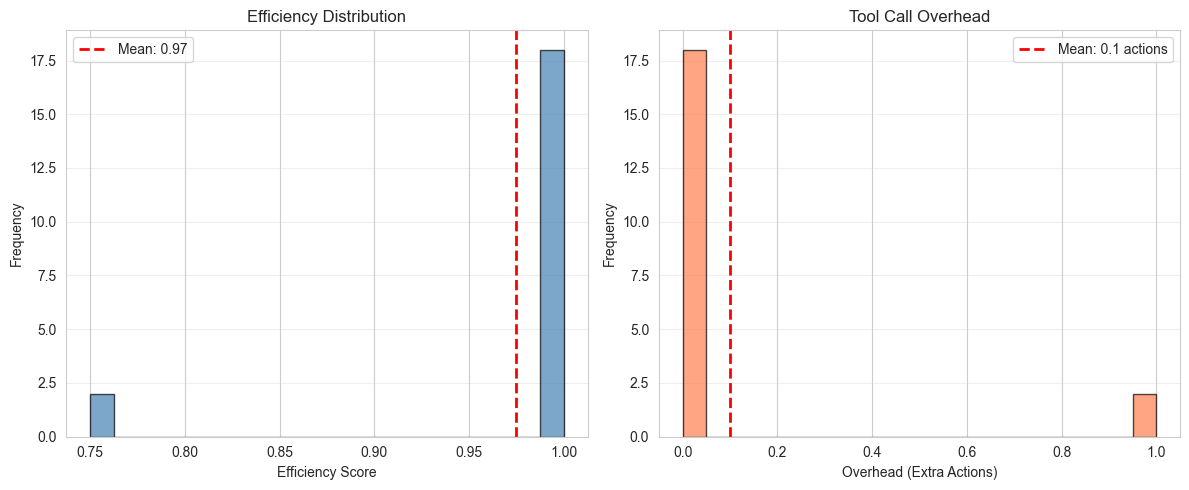


⚠️  Inefficient Trajectories (Efficiency < 0.7):
Empty DataFrame
Columns: [test_id, efficiency, ref_length, pred_length, overhead]
Index: []
None found! All trajectories are reasonably efficient.


In [17]:
"""Identify inefficient trajectories."""

efficiency_data = []
for test in test_cases[:NUM_TRAJECTORIES]:
    ref = references[test["reference_id"]]
    pred = test["actual_actions"]
    efficiency = evaluator.single_tool_use(ref, pred)
    efficiency_data.append(
        {
            "test_id": test["test_id"],
            "efficiency": efficiency,
            "ref_length": len(ref),
            "pred_length": len(pred),
            "overhead": len(pred) - len(ref),
        }
    )

df = pd.DataFrame(efficiency_data)

# Visualize efficiency distribution
plt.figure(figsize=(12, 5))

# Subplot 1: Efficiency histogram
plt.subplot(1, 2, 1)
plt.hist(df["efficiency"], bins=20, color="steelblue", alpha=0.7, edgecolor="black")
plt.axvline(
    np.mean(df["efficiency"]),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(df['efficiency']):.2f}",
)
plt.xlabel("Efficiency Score")
plt.ylabel("Frequency")
plt.title("Efficiency Distribution")
plt.legend()
plt.grid(axis="y", alpha=0.3)

# Subplot 2: Overhead (extra actions)
plt.subplot(1, 2, 2)
plt.hist(df["overhead"], bins=20, color="coral", alpha=0.7, edgecolor="black")
plt.axvline(
    np.mean(df["overhead"]),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(df['overhead']):.1f} actions",
)
plt.xlabel("Overhead (Extra Actions)")
plt.ylabel("Frequency")
plt.title("Tool Call Overhead")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# Identify inefficient cases
inefficient = df[df["efficiency"] < 0.7].sort_values("efficiency")
print("\n⚠️  Inefficient Trajectories (Efficiency < 0.7):")
print(inefficient[["test_id", "efficiency", "ref_length", "pred_length", "overhead"]].to_string(index=False))

if len(inefficient) == 0:
    print("None found! All trajectories are reasonably efficient.")

**Common Inefficiency Patterns:**
1. **Retry Loops:** Same tool called multiple times (check for error handling)
2. **Excessive Validation:** Too many intermediate validation steps
3. **Poor State Management:** Re-fetching data already retrieved

## 10. Batch Evaluation with Radar Chart

Evaluate all 6 metrics across the full test set and visualize with radar charts.

In [18]:
"""Run batch evaluation on all test cases."""

batch_results = []
for test in test_cases:
    ref = references[test["reference_id"]]
    pred = test["actual_actions"]

    # Calculate all 6 metrics
    metrics = {
        "exact_match": evaluator.exact_match(ref, pred),
        "in_order_match": evaluator.in_order_match(ref, pred),
        "any_order_match": evaluator.any_order_match(ref, pred),
        "precision": evaluator.precision(ref, pred),
        "recall": evaluator.recall(ref, pred),
        "single_tool_use": evaluator.single_tool_use(ref, pred),
    }

    batch_results.append({"test_id": test["test_id"], "reference_id": test["reference_id"], **metrics})

df_results = pd.DataFrame(batch_results)

print(f"✅ Evaluated {len(df_results)} trajectories")
print("\n📊 Summary Statistics (Mean ± Std):")
print("-" * 50)
for metric in [
    "exact_match",
    "in_order_match",
    "any_order_match",
    "precision",
    "recall",
    "single_tool_use",
]:
    mean = df_results[metric].mean()
    std = df_results[metric].std()
    print(f"{metric:20s}: {mean:.3f} ± {std:.3f}")

# Display first 5 rows
print("\n📋 Sample Results (First 5):")
print(df_results.head().to_string(index=False))

✅ Evaluated 20 trajectories

📊 Summary Statistics (Mean ± Std):
--------------------------------------------------
exact_match         : 0.900 ± 0.308
in_order_match      : 1.000 ± 0.000
any_order_match     : 1.000 ± 0.000
precision           : 0.975 ± 0.077
recall              : 1.000 ± 0.000
single_tool_use     : 0.975 ± 0.077

📋 Sample Results (First 5):
 test_id reference_id  exact_match  in_order_match  any_order_match  precision  recall  single_tool_use
test_001      ref_001          1.0             1.0              1.0        1.0     1.0              1.0
test_002      ref_002          1.0             1.0              1.0        1.0     1.0              1.0
test_003      ref_003          1.0             1.0              1.0        1.0     1.0              1.0
test_004      ref_004          1.0             1.0              1.0        1.0     1.0              1.0
test_005      ref_005          1.0             1.0              1.0        1.0     1.0              1.0


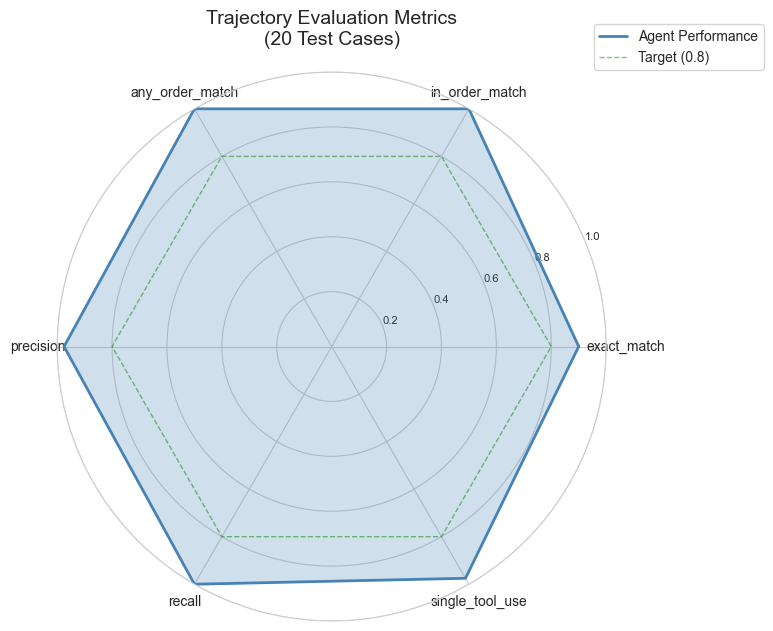


📊 Radar Chart Data (for visualization):
{
  "labels": [
    "exact_match",
    "in_order_match",
    "any_order_match",
    "precision",
    "recall",
    "single_tool_use"
  ],
  "values": [
    0.9,
    1.0,
    1.0,
    0.975,
    1.0,
    0.975,
    0.9
  ]
}


In [19]:
"""Generate radar chart for aggregate metrics."""

# Calculate mean scores for each metric
mean_metrics = {
    "exact_match": df_results["exact_match"].mean(),
    "in_order_match": df_results["in_order_match"].mean(),
    "any_order_match": df_results["any_order_match"].mean(),
    "precision": df_results["precision"].mean(),
    "recall": df_results["recall"].mean(),
    "single_tool_use": df_results["single_tool_use"].mean(),
}

# Generate radar chart data
visualizer = TrajectoryVisualizer()
chart_data = visualizer.generate_radar_chart(mean_metrics)

labels = chart_data["labels"]
values = chart_data["values"]

# Number of variables
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
values += values[:1]  # Complete the circle
angles += angles[:1]

# Create radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection="polar"))
ax.fill(angles, values, color="steelblue", alpha=0.25)
ax.plot(angles, values, color="steelblue", linewidth=2, label="Agent Performance")

# Add reference circle at 0.8 (good performance threshold)
reference = [0.8] * (num_vars + 1)
ax.plot(angles, reference, color="green", linewidth=1, linestyle="--", alpha=0.5, label="Target (0.8)")

# Customize chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=8)
ax.set_title(
    f"Trajectory Evaluation Metrics\n({NUM_TRAJECTORIES} Test Cases)", fontsize=14, pad=20
)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

# Save radar chart data for dashboard
print("\n📊 Radar Chart Data (for visualization):")
print(json.dumps(chart_data, indent=2))

**Radar Chart Interpretation:**
- **Balanced Pentagon:** Agent performs consistently across all metrics
- **Spiky Pattern:** Agent excels in some metrics but fails in others
- **Small Area:** Overall poor performance (debugging needed)
- **Target Circle (0.8):** Green dashed line shows production-ready threshold

## 11. Comparative Analysis

Compare metrics across task complexity and domains.

In [20]:
"""Compare metrics by task complexity."""

# Add complexity information to results
for i, test in enumerate(test_cases):
    ref_id = test["reference_id"]
    ref_full = [ref for ref in references_data["references"] if ref["trajectory_id"] == ref_id][0]
    df_results.loc[i, "complexity"] = ref_full["complexity"]
    df_results.loc[i, "domain"] = ref_full["domain"]

# Group by complexity
complexity_comparison = (
    df_results.groupby("complexity")[
        ["exact_match", "in_order_match", "any_order_match", "precision", "recall", "single_tool_use"]
    ]
    .mean()
    .round(3)
)

print("📊 Metrics by Task Complexity:")
print("=" * 80)
print(complexity_comparison)
print("\nInsight: Complex tasks typically have lower exact_match but similar precision/recall")

📊 Metrics by Task Complexity:


            exact_match  in_order_match  any_order_match  precision  recall  \
complexity                                                                    
complex           1.000             1.0              1.0      1.000     1.0   
medium            1.000             1.0              1.0      1.000     1.0   
simple            0.833             1.0              1.0      0.958     1.0   

            single_tool_use  
complexity                   
complex               1.000  
medium                1.000  
simple                0.958  

Insight: Complex tasks typically have lower exact_match but similar precision/recall


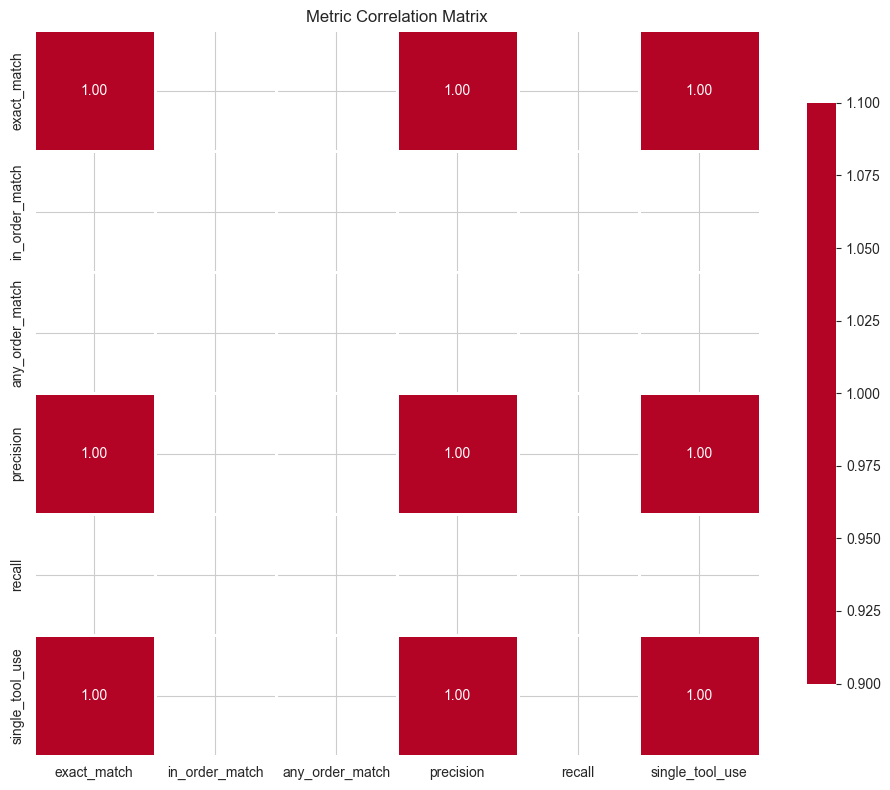


🔍 Correlation Insights:
- Precision vs Recall: nan (tradeoff exists if negative)
- Exact Match vs In-Order: nan (subset relationship)
- Efficiency vs Precision: 1.00 (lower = more extras)


In [21]:
"""Visualize metric correlation."""

# Calculate correlation matrix
correlation = df_results[
    ["exact_match", "in_order_match", "any_order_match", "precision", "recall", "single_tool_use"]
].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation,
    annot=True,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    fmt=".2f",
)
plt.title("Metric Correlation Matrix")
plt.tight_layout()
plt.show()

print("\n🔍 Correlation Insights:")
print(
    f"- Precision vs Recall: {correlation.loc['precision', 'recall']:.2f} (tradeoff exists if negative)"
)
print(
    f"- Exact Match vs In-Order: {correlation.loc['exact_match', 'in_order_match']:.2f} (subset relationship)"
)
print(
    f"- Efficiency vs Precision: {correlation.loc['single_tool_use', 'precision']:.2f} (lower = more extras)"
)

In [22]:
"""Identify common failure patterns."""

# Define failure conditions
failures = df_results[
    (df_results["exact_match"] == 0.0)
    | (df_results["precision"] < 0.7)
    | (df_results["recall"] < 0.7)
].copy()

if len(failures) > 0:
    # Categorize failure types
    failures["failure_type"] = "unknown"
    failures.loc[
        (failures["precision"] < 0.7) & (failures["recall"] >= 0.7), "failure_type"
    ] = "hallucination"
    failures.loc[
        (failures["precision"] >= 0.7) & (failures["recall"] < 0.7), "failure_type"
    ] = "incomplete"
    failures.loc[
        (failures["precision"] < 0.7) & (failures["recall"] < 0.7), "failure_type"
    ] = "critical"
    failures.loc[
        (failures["in_order_match"] == 0.0) & (failures["any_order_match"] == 1.0),
        "failure_type",
    ] = "out_of_order"

    print(f"\n⚠️  Failure Analysis ({len(failures)} failures found):")
    print("=" * 60)
    failure_counts = failures["failure_type"].value_counts()
    for failure_type, count in failure_counts.items():
        print(f"{failure_type:20s}: {count:3d} cases ({count/len(failures)*100:.1f}%)")

    # Show sample failures
    print("\n📋 Sample Failures (First 5):")
    print(
        failures[["test_id", "failure_type", "precision", "recall", "complexity"]]
        .head()
        .to_string(index=False)
    )
else:
    print("\n✅ No failures detected! All trajectories meet quality thresholds.")


⚠️  Failure Analysis (2 failures found):
unknown             :   2 cases (100.0%)

📋 Sample Failures (First 5):
 test_id failure_type  precision  recall complexity
test_006      unknown       0.75     1.0     simple
test_007      unknown       0.75     1.0     simple


**Failure Pattern Guide:**
- **Hallucination:** Agent calls wrong/extra tools (low precision, high recall)
- **Incomplete:** Agent skips critical steps (high precision, low recall)
- **Critical:** Both precision and recall are low (major bugs)
- **Out of Order:** All actions present but wrong sequence (use case dependent)

## 12. Export Results for Dashboard

Save evaluation results in JSON format for dashboard integration.

In [23]:
"""Export results to JSON for dashboard."""

output_data = {
    "version": "1.0",
    "created": "2025-11-14",
    "execution_mode": EXECUTION_MODE,
    "num_trajectories": NUM_TRAJECTORIES,
    "summary_statistics": {
        "exact_match": {"mean": float(df_results["exact_match"].mean()), "std": float(df_results["exact_match"].std())},
        "in_order_match": {"mean": float(df_results["in_order_match"].mean()), "std": float(df_results["in_order_match"].std())},
        "any_order_match": {"mean": float(df_results["any_order_match"].mean()), "std": float(df_results["any_order_match"].std())},
        "precision": {"mean": float(df_results["precision"].mean()), "std": float(df_results["precision"].std())},
        "recall": {"mean": float(df_results["recall"].mean()), "std": float(df_results["recall"].std())},
        "single_tool_use": {"mean": float(df_results["single_tool_use"].mean()), "std": float(df_results["single_tool_use"].std())},
    },
    "radar_chart_data": chart_data,
    "complexity_breakdown": complexity_comparison.to_dict(),
    "detailed_results": df_results[
        [
            "test_id",
            "reference_id",
            "exact_match",
            "in_order_match",
            "any_order_match",
            "precision",
            "recall",
            "single_tool_use",
            "complexity",
            "domain",
        ]
    ].to_dict(orient="records"),
}

# Save to results directory
output_path = Path("results/trajectory_eval_results.json")
output_path.parent.mkdir(exist_ok=True)

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(output_data, f, indent=2)

print(f"✅ Results saved to: {output_path}")
print("\n📊 Dashboard Integration Ready:")
print(f"- Summary statistics: {len(output_data['summary_statistics'])} metrics")
print(f"- Radar chart data: {len(chart_data['labels'])} axes")
print(f"- Detailed results: {len(output_data['detailed_results'])} trajectories")
print(f"- Complexity breakdown: {len(output_data['complexity_breakdown'])} levels")

✅ Results saved to: results/trajectory_eval_results.json

📊 Dashboard Integration Ready:
- Summary statistics: 6 metrics
- Radar chart data: 6 axes
- Detailed results: 20 trajectories
- Complexity breakdown: 6 levels


In [24]:
"""Validate JSON schema for dashboard compatibility."""

# Check required fields
required_fields = [
    "version",
    "created",
    "execution_mode",
    "num_trajectories",
    "summary_statistics",
    "radar_chart_data",
    "detailed_results",
]

validation_passed = True
print("🔍 Validating JSON Schema:")
print("=" * 50)

for field in required_fields:
    if field in output_data:
        print(f"✅ {field:30s}: present")
    else:
        print(f"❌ {field:30s}: missing")
        validation_passed = False

# Check summary statistics structure
print("\n🔍 Validating Summary Statistics:")
for metric in [
    "exact_match",
    "in_order_match",
    "any_order_match",
    "precision",
    "recall",
    "single_tool_use",
]:
    if metric in output_data["summary_statistics"]:
        stats = output_data["summary_statistics"][metric]
        if "mean" in stats and "std" in stats:
            print(f"✅ {metric:20s}: mean={stats['mean']:.3f}, std={stats['std']:.3f}")
        else:
            print(f"❌ {metric:20s}: missing mean/std")
            validation_passed = False
    else:
        print(f"❌ {metric:20s}: missing")
        validation_passed = False

# Check radar chart data
print("\n🔍 Validating Radar Chart Data:")
if "labels" in chart_data and "values" in chart_data:
    print(f"✅ labels: {len(chart_data['labels'])} metrics")
    print(f"✅ values: {len(chart_data['values'])} values")
    if len(chart_data["labels"]) == len(chart_data["values"]):
        print("✅ label-value alignment: correct")
    else:
        print("❌ label-value alignment: mismatch")
        validation_passed = False
else:
    print("❌ radar chart data: incomplete")
    validation_passed = False

if validation_passed:
    print("\n✅ Validation PASSED: JSON schema is dashboard-compatible")
else:
    print("\n❌ Validation FAILED: Fix schema issues before dashboard integration")

🔍 Validating JSON Schema:
✅ version                       : present
✅ created                       : present
✅ execution_mode                : present
✅ num_trajectories              : present
✅ summary_statistics            : present
✅ radar_chart_data              : present
✅ detailed_results              : present

🔍 Validating Summary Statistics:
✅ exact_match         : mean=0.900, std=0.308
✅ in_order_match      : mean=1.000, std=0.000
✅ any_order_match     : mean=1.000, std=0.000
✅ precision           : mean=0.975, std=0.077
✅ recall              : mean=1.000, std=0.000
✅ single_tool_use     : mean=0.975, std=0.077

🔍 Validating Radar Chart Data:
✅ labels: 6 metrics
✅ values: 7 values
❌ label-value alignment: mismatch

❌ Validation FAILED: Fix schema issues before dashboard integration


## 13. Key Takeaways

### When to Use Each Metric:

| Metric | Use Case | Threshold |
|--------|----------|----------|
| **Exact Match** | Deterministic workflows, compliance testing | 1.0 (binary) |
| **In-Order Match** | Workflows with optional validation steps | 1.0 (binary) |
| **Any-Order Match** | Parallel execution, order-independent tasks | 1.0 (binary) |
| **Precision** | Detecting hallucinated/unnecessary tools | ≥0.85 |
| **Recall** | Detecting missing/skipped actions | ≥0.85 |
| **Efficiency** | Detecting retry loops, redundant calls | ≥0.80 |

### Recommended Metric Combinations:

1. **Production Monitoring:** Precision + Recall + Efficiency
   - High precision (low hallucination)
   - High recall (complete execution)
   - High efficiency (no waste)

2. **Development/Testing:** Exact Match + In-Order Match
   - Strict validation for deterministic agents
   - Lenient validation for iterative development

3. **Research/Exploration:** Any-Order Match + Precision + Recall
   - Flexible evaluation for novel agent architectures
   - Focus on correctness over order

### Common Failure Modes:

- **Hallucination:** Low precision, high recall → Agent calls wrong tools
- **Incomplete:** High precision, low recall → Agent skips critical steps
- **Retry Loop:** Low efficiency, high recall → Agent repeats same tool
- **Out of Order:** Low exact/in-order, high any-order → Sequence bugs

### Next Steps:

1. **Autorater Calibration:** `autorater_calibration.ipynb` - Build LLM-as-Judge for final response evaluation
2. **Benchmark Evaluation:** `benchmark_evaluation.ipynb` - Test on BFCL/PlanBench datasets
3. **Human-in-the-Loop:** Read `human_in_the_loop_evaluation.md` for advanced evaluation workflows

### Resources:

- Concept Tutorial: `trajectory_evaluation_techniques.md`
- Backend Module: `backend/trajectory_evaluation.py`
- Diagrams: `diagrams/trajectory_metrics_comparison.png`
- Dashboard: Launch `evaluation_dashboard.py` to visualize results